In [ ]:
from pathlib import Path

from cool_styles import coastalarvest
from openpyxl import load_workbook

import pandas as pd
from matplotlib import pyplot as plt

from thesis_breath_frequency.project_configs import ProjectPaths

project_paths = ProjectPaths()

plt.style.use(coastalarvest)

source_excel_path = project_paths.data_folder.raw.joinpath("Respiratorio CPET BR.xlsx")

header = [
    "Time (min)",
    "Work (Watts)",
    "VO2 (mL/kg/min)",
    "VO2 (mL/min)",
    "VCO2 (mL/min)",
    "RER",
    "RR (br/min)",
    "Vt BTPS (L)",
    "VE BTPS (L/min)",
    "BR (%)",
    "HR (BPM)",
    "HRR (%)",
    "PETO2 (mmHg)",
    "PETCO2 (mmHg)",
    "RR (br/min) copy",
    "VO2/Pred (%)",
    "Ti/Ttot",
    "Ti (sec)",
    "Te (sec)",
    "Ttot (sec)",
    "msec",
    "msec_diff_quad",
    "RMSSQ",
]

In [50]:
def normalize_columns(df_: pd.DataFrame) -> pd.DataFrame:
    df_.columns = [
        col.strip()
        .lower()
        .replace(" ", "_")
        for col in df_.columns
    ]
    return df_


def convert_time_to_seconds(time_str: str) -> int:
    if isinstance(time_str, str):
        hours, minutes, seconds = time_str.split(":")
        minutes = int(minutes) + int(hours) * 60
        seconds = int(seconds) + minutes * 60
        return seconds
    else:
        raise ValueError(f"Expected a string in the format 'HH:MM:SS', got {time_str}")


def correct_df_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    # 1. Strip whitespace from all string columns
    str_cols = df.select_dtypes(include=["object", "string"]).columns
    for col in str_cols:
        df[col] = df[col].astype(str).str.strip()

    # 2. Attempt to convert string columns to numeric where possible
    for col in str_cols:
        # check if the column is primarily digits/decimals
        # errors='ignore' keeps it as string if it's not a number
        converted = pd.to_numeric(df[col], errors="coerce")

        # If the conversion didn't result in all NaNs (meaning it was actually numbers)
        if not converted.isna().all():
            df[col] = converted

    return df


dataframes = []
for sheet_name in load_workbook(source_excel_path, read_only=True).sheetnames:
    match sheet_name:
        case "FG":
            skip_to_row = 3
        case "VR":
            skip_to_row = 4
        case "CN":
            skip_to_row = 4
        case "SG":
            skip_to_row = 3
        case "AA":
            skip_to_row = 4
        case "MS":
            skip_to_row = 4
        case "GE":
            skip_to_row = 4
        case "PT":
            skip_to_row = 4
        case "CM":
            skip_to_row = 3
        case "CN2":
            skip_to_row = 4
        case "CG":
            skip_to_row = 3
        case "MP":
            skip_to_row = 3
        case "IL":
            skip_to_row = 4
        case "GR":
            skip_to_row = 4
        case "VG":
            skip_to_row = 4
        # TODO: controlla SM
        # case "SM":
        #     skip_to_row = 2
        case "GP":
            skip_to_row = 4
        case "CL":
            skip_to_row = 4
        case "GM":
            skip_to_row = 4
        case "SL":
            skip_to_row = 4
        case _:
            print(f"Skipping sheet {sheet_name}")
            continue

    dataframes.append(
        pd.read_excel(
            source_excel_path,
            sheet_name=sheet_name,
            skiprows=skip_to_row,
            usecols="A:W",
            names=header,
            dtype="string",
        )
        .pipe(normalize_columns)
        .dropna(thresh=20)
        .assign(
            patient=sheet_name,
            time_seconds=lambda df_: df_["time_(min)"].apply(convert_time_to_seconds),
        )
        .drop(columns=["time_(min)"])
        .pipe(correct_df_dtypes)
    )

final_dataframe = pd.concat(dataframes)
final_dataframe
# TODO: rename the columns

Skipping sheet STATISTICA
Skipping sheet Breathing-Rate Variability
Skipping sheet SM


,work_(watts),vo2_(ml/kg/min),vo2_(ml/min),vco2_(ml/min),rer,rr_(br/min),vt_btps_(l),ve_btps_(l/min),br_(%),hr_(bpm),...,vo2/pred_(%),ti/ttot,ti_(sec),te_(sec),ttot_(sec),msec,msec_diff_quad,rmssq,patient,time_seconds
0,0,6.5,633,578,0.91,22,0.89,19.4,89.1,81,...,22,0.43,1.18,1.57,2.74,2740.0,400.0,0.042975,FG,14880
1,0,6.6,638,578,0.91,22,0.87,19.3,89.2,83,...,22,0.43,1.16,1.56,2.72,2720.0,10000.0,NaN,FG,15060
2,0,7.0,676,609,0.90,21,0.94,20.0,88.8,83,...,23,0.43,1.21,1.61,2.82,2820.0,900.0,NaN,FG,15240
3,1,7.4,719,644,0.90,21,0.99,20.8,88.3,83,...,25,0.44,1.24,1.60,2.85,2850.0,900.0,NaN,FG,15420
4,2,7.5,726,651,0.90,21,1.01,21.0,88.2,83,...,25,0.44,1.26,1.62,2.88,2880.0,16900.0,NaN,FG,15600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,151,31.1,1243,1099,0.88,30,0.81,24.0,73.6,142,...,,0.35,0.72,1.31,2.03,2030.0,2500.0,NaN,CL,34980
199,152,30.8,1234,1090,0.88,29,0.81,23.4,74.3,142,...,,0.38,0.78,1.30,2.08,2080.0,0.0,NaN,CL,35100
201,152,32.5,1301,1158,0.89,30,0.82,25.0,72.4,143,...,,0.38,0.75,1.23,1.98,1980.0,14400.0,78.102497,CL,35220
202,153,33.7,1346,1189,0.88,32,0.80,25.8,71.6,147,...,,0.38,0.70,1.16,1.86,1860.0,10000.0,NaN,CL,35340


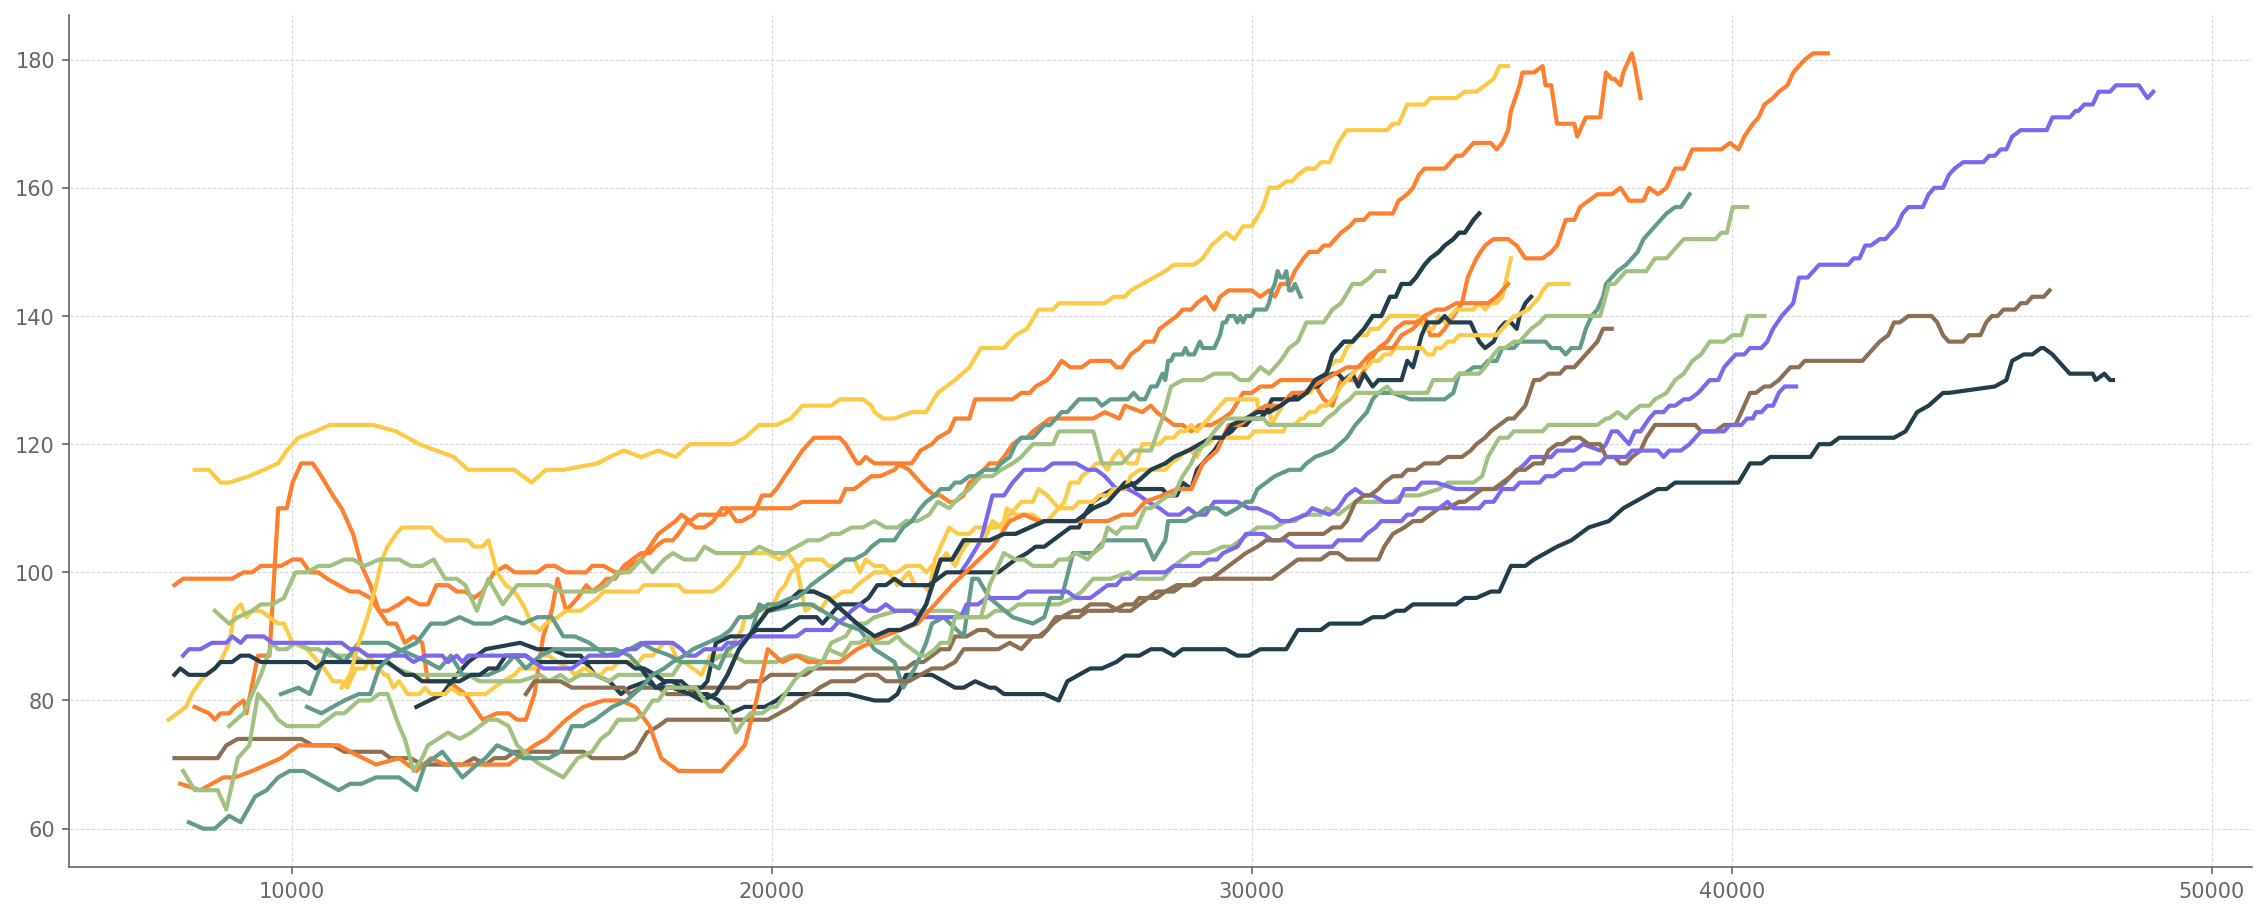

In [54]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))

for patient, group in final_dataframe.groupby("patient"):
    ax.plot(group["time_seconds"], group["hr_(bpm)"], label=patient)